In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.feature_selection import f_classif
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

In [21]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.head()

VASK0  VASK1  VASK2  VASK3  ...  VBID2_PREV  VBID3_PREV  VBID4_PREV  Y
0    108    276    224    196  ...         253         207         185  0
1     47    132    197    236  ...         193         169         192  0
2     93    172    193    226  ...         168         145         140  0
3     62    104    169    188  ...         151         206         105  0
4     40     43     87    110  ...          77         153         364  0

[5 rows x 21 columns]

### Feature selection

To reduce dimensionality, I take differences of ask and bid volumes at each level respectively. Also, I calculate volatility for the last 5 time steps and deviation from mean of VASK0 and VBID0.

In [40]:
def get_features(data, test = 0):
    df = dict()
    for col in range(5):
        df['DIFF'+str(col)] = data.iloc[:, col] - data.iloc[:, col + 5]
    for col in range(10, 15):
        df['DIFF'+str(col-10) + 'PREV'] = data.iloc[:, col] - data.iloc[:, col + 5]
    
    if test == 0:
        df['Y']=data['Y']
        dat = data.drop(columns = ['Y'])
    else:
        dat = data.copy()

    df = pd.DataFrame(df)
    df['vol'] = 0
    for i in range(5, data.shape[0] + 1):
            df.at[i-1, 'vol'] = df.iloc[i-5:i, 0].std()
    df['ask_deviation_mean'] = data['VASK0'] - data['VASK0'].mean()
    df['bid_deviation_mean'] = data['VBID0'] - data['VBID0'].mean()

    return df

In [41]:
final_test = get_features(test, 1)
features = get_features(train)
features.head()

DIFF0  DIFF1  DIFF2  DIFF3  ...  Y  vol  ask_deviation_mean  bid_deviation_mean
0    -24     95    -29    -11  ...  0    0           15.211019           39.729755
1    -34    -14      4     67  ...  0    0          -45.788981          -11.270245
2     60     44     25     81  ...  0    0            0.211019          -59.270245
3    -13    -61     18    -18  ...  0    0          -30.788981          -17.270245
4     29    -23     10    -45  ...  0   39          -52.788981          -81.270245

[5 rows x 14 columns]

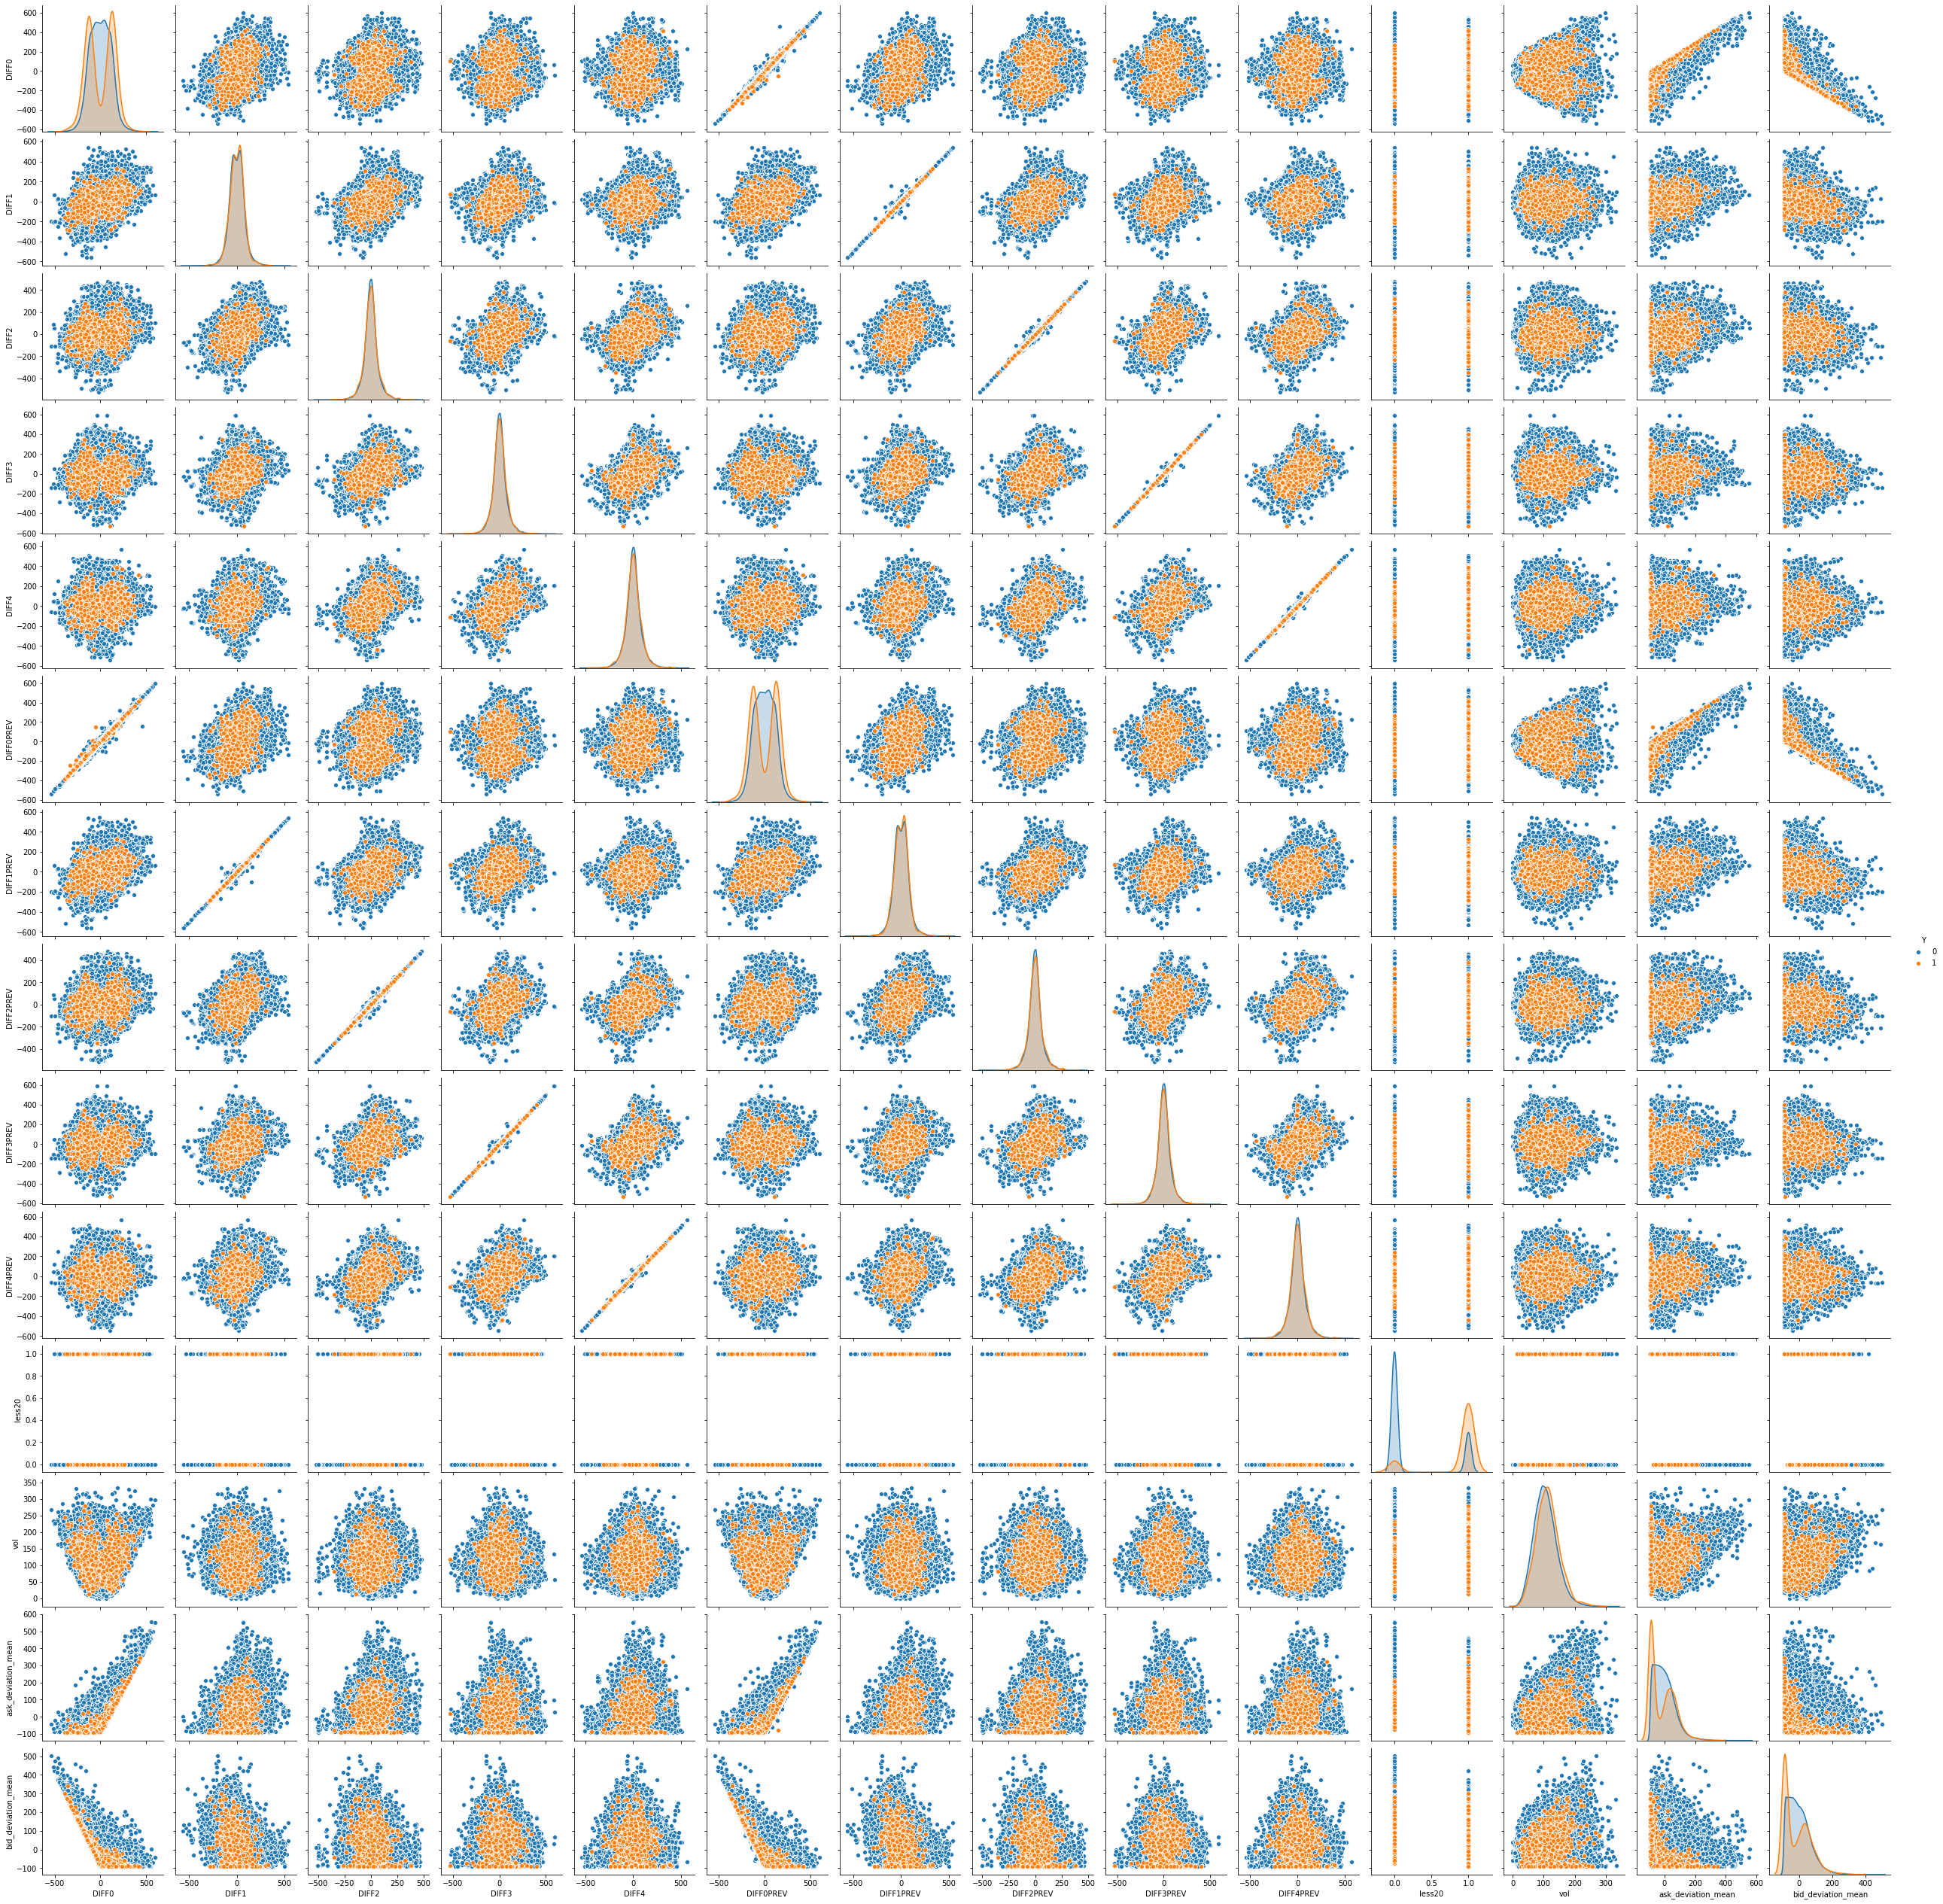

In [ ]:
import seaborn as sns
sns.pairplot(features, hue = 'Y');

I plot correlation matrix to see relationships between new features. It can be observed that deviation from means of VASK0 and VBID0 and volatility have highest correlation with Y. This is supported by feature importance from decision tree and ANOVA test. So I include these 4 features and DIFF0 and DIFF0PREV as indicated by decision tree.

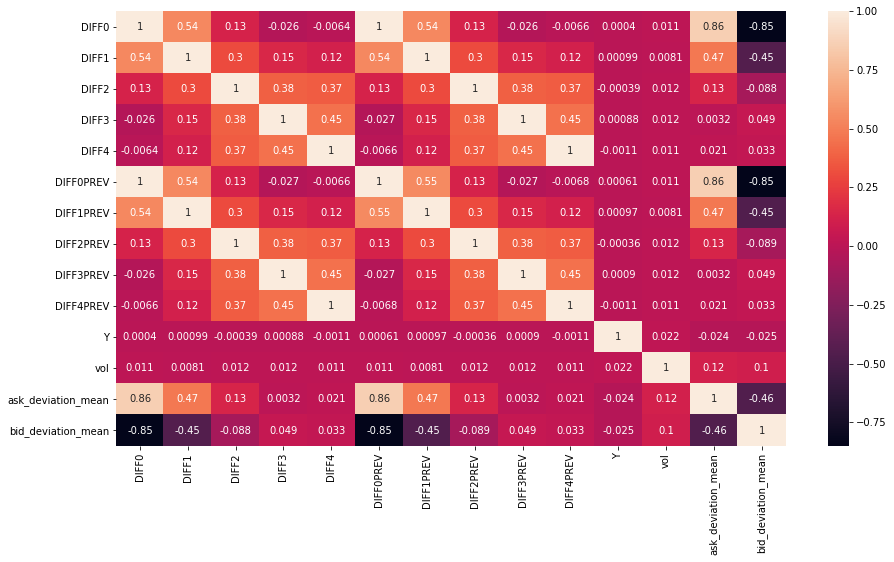

In [53]:
plt.figure(figsize = (15, 8))
sns.heatmap(features.corr(), annot=True);

#### Decision tree feature importance

[0.08702957 0.05684862 0.05170788 0.05212622 0.05185447 0.073387
 0.05687779 0.05342159 0.05200336 0.05286613 0.05973704 0.18215268
 0.16998766]


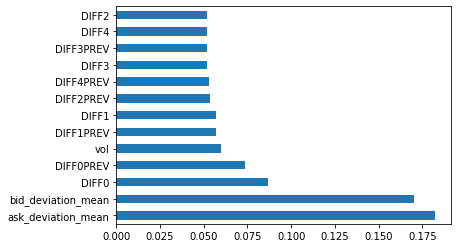

In [56]:
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier(criterion = 'gini', min_samples_leaf = 5, random_state = 3)
model.fit(features.drop(columns = ['Y']), features['Y'])
print(model.feature_importances_)
feat_importances = pd.Series(model.feature_importances_, index=features.drop(columns = ['Y']).columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.show()

#### ANOVA test
Small p-values indicate relevant features. 

In [55]:
feat_selected = f_classif(features.drop(columns = ['Y']), features['Y'])[1] #p-values
feat_selected_df = pd.DataFrame([features.drop(columns = ['Y']).columns, feat_selected])
feat_selected_df = feat_selected_df.transpose()
feat_selected_df.columns = ['variable', 'p-value']
feat_selected_df.sort_values(by = ['p-value']).head(7)

variable      p-value
12  bid_deviation_mean  1.64673e-27
11  ask_deviation_mean   3.0629e-25
10                 vol  1.58108e-21
9            DIFF4PREV     0.636899
4                DIFF4     0.640075
1                DIFF1     0.667849
6            DIFF1PREV     0.674694

I split data in train (70%) and hold-out dataset (30%). Normally, I would do cross-validation, but here I go with a simpler approach because of time constraints.

In [57]:
X = features[['bid_deviation_mean', 'ask_deviation_mean', 'vol', 'DIFF0', 'DIFF0PREV']]
Y = features['Y']
idx = int(0.7 * X.shape[0])
X_train, X_test, Y_train, Y_test = X.iloc[:idx, :], X.iloc[idx:, :], Y.iloc[:idx], Y.iloc[idx:]

In [58]:
for_prediction = final_test[[ 'bid_deviation_mean', 'ask_deviation_mean', 'vol', 'DIFF0', 'DIFF0PREV']]

#### SMOTE

The dataset is imbalanced, so I oversample class 1 using SMOTE algorithm, which basically synthesizes examples of minority class.

In [59]:
from imblearn.over_sampling import SMOTE
smt = SMOTE(sampling_strategy = 0.1, random_state=0)
X_train_SMOTE, Y_train_SMOTE = smt.fit_sample(X_train, Y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


### Models

#### KNN with DTW
First I tried KNN regression with dynamic time warping (DTW) (to account for any time-dependent relationships). DTW is used to measure similarity between time series, so it can be used as distance metric in KNN. KNN has long been a benchmark for time series classification. I used regression not classifier since I want to be able to choose different threshold values to separate classes (this may be useful as data is imbalanced and it turned out the algorithm did worse on SMOTE data). I classified as 1 if the prediction was > 0.

In [ ]:
idx = int(0.7 * X.shape[0])
X_train_knn, X_test_knn, Y_train_knn, Y_test_knn = X.iloc[:idx, :].reset_index(), X.iloc[idx:, :].reset_index(), Y.iloc[:idx].reset_index(), Y.iloc[idx:].reset_index()

In [ ]:
from tslearn.metrics import dtw 
from sklearn.neighbors import KNeighborsRegressor

auc_all = list()
for n in range(3, 16):
    print('{} neighbours'.format(n))
    part_auc = []
    ind_end = 20000
    while ind_end <= 23000:
        neigh = KNeighborsRegressor(n_neighbors=n, metric = dtw, weights = 'distance', n_jobs = -1)
        neigh.fit(X_train_knn.iloc[:ind_end, 1:], Y_train_knn.iloc[:ind_end, 1])
        knn_pred = neigh.predict(X_test_knn.iloc[ind_end-20000:ind_end - 19000, 1:])
        knn_pred[knn_pred > 0] = 1
        part_auc.append(roc_auc_score(Y_test_knn.iloc[ind_end-20000:ind_end - 19000, 1], knn_pred))
        ind_end += 1000
    auc_all.append(np.mean(part_auc))

3 neighbours
4 neighbours
5 neighbours
6 neighbours
7 neighbours
8 neighbours
9 neighbours
10 neighbours
11 neighbours
12 neighbours
13 neighbours
14 neighbours
15 neighbours


AUC generally improves with more neighbours. I used K=15 neigbours at maximum, and the best result seems to be K=14. However, the algorithm is extremely slow at making predictions, so I decided not to proceed with it.

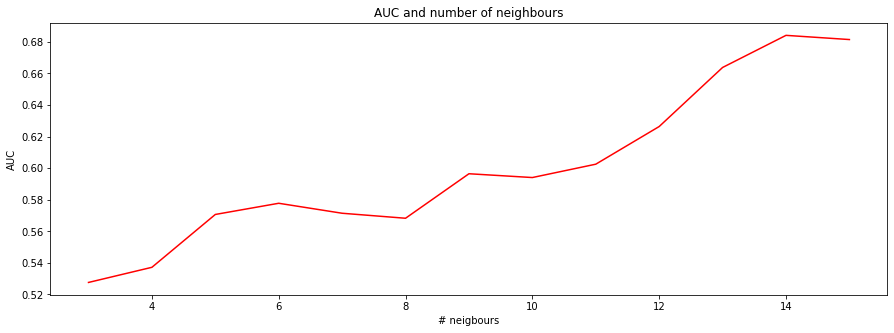

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(np.arange(3,16,1), auc_all, c = 'r')
plt.xlabel('# neigbours')
plt.ylabel('AUC')
plt.title('AUC and number of neighbours');

#### Logistic regression

Next, I tried logistic regression with cross-validation. It did not converge with original data even after 10000 iterations, and it did not converge with SMOTE data either. This may indicate the model is not suitable for the data.

In [60]:
from sklearn.linear_model import LogisticRegressionCV
cvlog = LogisticRegressionCV(penalty = 'l2', class_weight = 'balanced', cv = 3, solver = 'saga', n_jobs = -1, refit = True,
                             random_state=0, max_iter = 1000, scoring = 'roc_auc').fit(X_train_SMOTE, Y_train_SMOTE)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [61]:
logit_pred = pd.DataFrame(cvlog.predict_proba(X_test))
logit_pred = logit_pred.iloc[:,1]
roc_auc_score(Y_test, logit_pred)

0.6670742641818538

#### Decision trees with gradient boosting

First, I try to tune parameters for the classifier using grid search. I use non-SMOTE data since boosting should naturally account for the imbalance. It turns out that training smaller number of trees produces better results.

In [ ]:
n_features = np.sqrt(X_train.shape[1])/X_train.shape[1]
xgb_grid = xgb.XGBClassifier(booster = 'gbtree', n_estimators = 1000, colsample_bytree = n_features)
params = {
     "eta"    : [0.1, 0.2, 0.3] ,
     "max_depth"        : [2, 3, 4],
     "gamma"            : [ 0.0, 0.1, 0.2 , 0.3]}

grid = GridSearchCV(xgb_grid,
                    params, n_jobs=-1,
                    scoring="roc_auc",
                    cv=3)

grid.fit(X_train, Y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster='gbtree',
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.447213595499958,
                                     gamma=None, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=4000, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,

In [ ]:
grid.best_params_

{'eta': 0.1, 'gamma': 0.3, 'max_depth': 2}

In [62]:
n_features = np.sqrt(X_train.shape[1])/X_train.shape[1]
w = Y[Y == 0].shape[0]/ Y[Y == 1].shape[0]
boosting = xgb.XGBClassifier(n_estimators = 1000, booster = 'gbtree', subsample = 0.3, colsample_bytree = n_features, learning_rate = 0.1, 
                             gamma = 0.3, max_depth = 2)
boosting.fit(X_train, Y_train, eval_metric = 'auc')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.447213595499958, gamma=0.3,
              learning_rate=0.1, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.3, verbosity=1)

In [63]:
boost_pred = pd.DataFrame(boosting.predict_proba(X_test))
boost_pred = boost_pred.iloc[:,1]
roc_auc_score(Y_test, boost_pred)

0.8870945035275359

Out of all tested algorithms, decision tress seem to be the best. This is because they produce more complex boundary and thus can in general separate classes better. 

In [72]:
fin_pred = pd.DataFrame(boosting.predict_proba(for_prediction))
fin_pred = fin_pred.iloc[:, 1]

In [74]:
fin_pred.to_csv('prediction.csv', index = False)